<a href="https://colab.research.google.com/github/likhi-23/Heart-disease-prediction/blob/main/dnn_unswb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.7592 - loss: 0.5457 - val_accuracy: 0.5066 - val_loss: 0.7397 - learning_rate: 0.0010
Epoch 2/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8535 - loss: 0.3140 - val_accuracy: 0.7724 - val_loss: 0.5756 - learning_rate: 0.0010
Epoch 3/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8797 - loss: 0.2606 - val_accuracy: 0.7312 - val_loss: 0.6053 - learning_rate: 0.0010
Epoch 4/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8927 - loss: 0.2306 - val_accuracy: 0.4963 - val_loss: 0.7454 - learning_rate: 0.0010
Epoch 5/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9030 - loss: 0.2094 - val_accuracy: 0.7882 - val_loss: 0.5594 - learning_rate: 0.0010
Epoch 6/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9065 - loss: 0.1987 - val_accuracy: 0.7311 - val_loss: 0.6193 - learning_rate: 0.0010
Epoch 7/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9185 - loss: 0.18

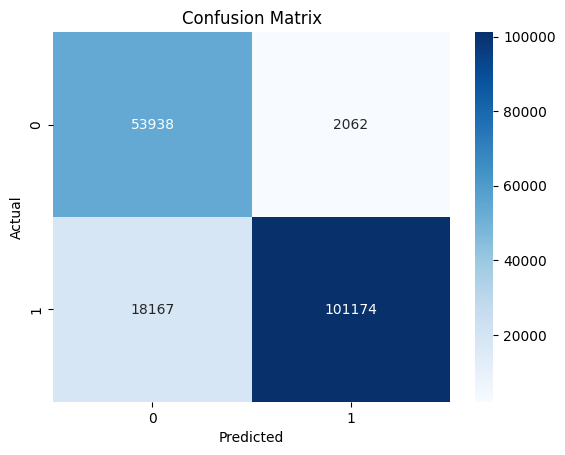

In [22]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import ADASYN
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, LeakyReLU, ReLU, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# Load Data
train_df = pd.read_csv('/content/UNSW_NB15_training-set.csv')
test_df = pd.read_csv('/content/UNSW_NB15_testing-set.csv')
# Drop 'id' column
train_df = train_df.drop(columns=['id', 'attack_cat'])
test_df = test_df.drop(columns=['id', 'attack_cat'])

# Combine datasets for consistent encoding
combined_df = pd.concat([train_df, test_df])
categorical_columns = combined_df.select_dtypes(include='object').columns

# Label Encode categorical features
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    combined_df[col] = le.fit_transform(combined_df[col])
    label_encoders[col] = le

# Split combined dataset back
train_df = combined_df.iloc[:len(train_df)]
test_df = combined_df.iloc[len(train_df):]

# Extract features and target
X_train = train_df.drop(columns=['label']).values
y_train = train_df['label'].values
X_test = test_df.drop(columns=['label']).values
y_test = test_df['label'].values

# Standardize features
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Balance data using ADASYN
adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train_scaled, y_train)

# Compute class weights
unique_classes = np.unique(y_train_resampled)
class_weights = compute_class_weight(class_weight='balanced', classes=unique_classes, y=y_train_resampled)
class_weights = dict(enumerate(class_weights))

# Convert labels to one-hot encoding
y_train_resampled_categorical = to_categorical(y_train_resampled, num_classes=len(unique_classes))
y_test_categorical = to_categorical(y_test, num_classes=len(unique_classes))

# Parallel ANN Model
def create_parallel_ann(input_shape, num_classes, learning_rate=0.001):
    inputs = Input(shape=input_shape)
    # Branch 1
    branch_1 = Dense(64, kernel_initializer='he_uniform')(inputs)
    branch_1 = LeakyReLU()(branch_1)
    branch_1 = BatchNormalization()(branch_1)
    branch_1 = Dropout(0.4)(branch_1)

    branch_1 = Dense(128, kernel_initializer='he_uniform')(branch_1)
    branch_1 = LeakyReLU()(branch_1)
    branch_1 = BatchNormalization()(branch_1)
    branch_1 = Dropout(0.4)(branch_1)

    # Branch 2
    branch_2 = Dense(128, kernel_initializer='he_uniform')(inputs)
    branch_2 = ReLU()(branch_2)
    branch_2 = BatchNormalization()(branch_2)
    branch_2 = Dropout(0.4)(branch_2)

    branch_2 = Dense(64, kernel_initializer='he_uniform')(branch_2)
    branch_2 = ReLU()(branch_2)
    branch_2 = BatchNormalization()(branch_2)
    branch_2 = Dropout(0.4)(branch_2)

     # Merge branches
    merged = concatenate([branch_1, branch_2])

    # Fully connected layers
    fc = Dense(256, kernel_initializer='he_uniform')(merged)
    fc = LeakyReLU()(fc)
    fc = BatchNormalization()(fc)
    fc = Dropout(0.4)(fc)

    outputs = Dense(num_classes, activation='softmax')(fc)

    # Compile the model
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Initialize and train the model
input_shape = X_train_resampled.shape[1:]
num_classes = y_train_resampled_categorical.shape[1]

model = create_parallel_ann(input_shape, num_classes)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(X_train_resampled, y_train_resampled_categorical,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=128,
                    class_weight=class_weights,
                    callbacks=[early_stopping, reduce_lr])

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test_scaled, y_test_categorical)
print(f"Test Accuracy: {test_acc:.4f}")

# Confusion Matrix
y_test_pred = model.predict(X_test_scaled)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

cm = confusion_matrix(y_test, y_test_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()